In [3]:
#|export
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

from miniai.training import *
from miniai.datasets import *

In [4]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

from torch.utils.data import DataLoader
from typing import Mapping

In [5]:
mpl.rcParams['image.cmap'] = 'gray'

In [6]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)
     

In [7]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In [61]:
x_imgs = x_train.view(-1, 28, 28)
xv_imgs = x_valid.view(-1, 28, 28)

In [11]:
mpl.rcParams['figure.dpi'] = 30

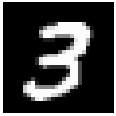

In [12]:
im3 = x_imgs[7]
show_image(im3);

In [14]:
top_edge = tensor([[-1,-1,-1],
                  [0,0,0],
                  [1,1,1]]).float()

<Axes: >

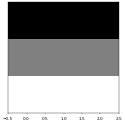

In [15]:
show_image(top_edge, noframe=False)

In [16]:
def apply_kernel(row, col, kernel):
    return (im3[row-1:row+2, col-1:col+2] * kernel).sum()

In [17]:
apply_kernel(4, 15, top_edge)

tensor(2.9727)

<Axes: >

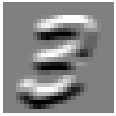

In [18]:
rng = range(1, 27)
top_edge3 = tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])
show_image(top_edge3)

In [19]:
left_edge = tensor([[-1,1,0],
                   [-1,1,0],
                   [-1,1,0]])

<Axes: >

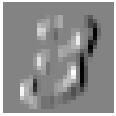

In [21]:
left_edge3 = tensor([[apply_kernel(i, j, left_edge) for j in rng] for i in rng])
show_image(left_edge3)

# Convolutions in Pytorch

In [8]:
import torch.nn.functional as F
import torch

In [9]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In [10]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [11]:
x_train.shape

torch.Size([50000, 784])

In [12]:
#x_imgs = x_train.view(-1, 28, 28)
#xv_imgs = x_valid.view(-1, 28, 28)

#xb = x_imgs[:16][:,None]
#xb.shape

In [13]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,10, kernel_size=3, padding=1)
)

In [15]:
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res

In [16]:
simple_cnn = nn.Sequential(
    conv(1,4),
    conv(4, 8),
    conv(8, 16),
    conv(16, 16),
    conv(16, 10, act=False),
    nn.Flatten(),
)

In [18]:
x_imgs = x_train.view(-1,1,28,28)
xv_imgs = x_valid.view(-1,1,28,28)
train_ds, valid_ds = Dataset(x_imgs, y_train), Dataset(xv_imgs, y_valid)

In [19]:
#|export
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

In [20]:
from torch import optim

bs = 256
lr = 0.4
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn = collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [21]:
loss, acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.7439095288515091 0.7394129127264023
1 0.17319558337330818 0.9461339622735977
2 0.12394648194313049 0.9628216922283173
3 0.14830244556069375 0.9526309758424759
4 0.13368072248995305 0.9616498172283172


In [22]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4)
loss, acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.09216977115720511 0.9729549646377563
1 0.0845085909590125 0.9761546403169632
2 0.0854754381813109 0.9752642452716828
3 0.08306600488722324 0.9758616715669632
4 0.08907164856791497 0.9742130070924759
